In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from catboost import Pool
import shap

In [3]:
train = pd.read_csv('./train.csv')

In [4]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [7]:
features = [col for col in train.columns if col not in ['row_id', 'time_id', 'target']]
print(features)

['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


In [8]:
train = train.dropna(subset=["target"])
train.reset_index(drop=True, inplace=True)

In [9]:
X = train[features].copy(deep=True)
y = train['target'].copy(deep=True)

In [10]:
number_of_days = len(X.date_id.unique()) # There are 481 trading days, we'll take the last n as testing set
testing_days = 10
training_days = number_of_days - testing_days
training_days, testing_days

# mask to grab the days for training and testing
training_mask = X.date_id <= training_days
testing_mask = X.date_id > training_days

# subset and make training and validation sets
X_train, X_val, y_train, y_val = X[training_mask], X[testing_mask], y[training_mask], y[testing_mask] #train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True, stratify=X['stock_id']) # random_state=8
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5138892, 14), (99000, 14), (5138892,), (99000,))

In [11]:
def feature_engineering(X):

    _X = X.copy()

    # features taken from https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver
    _X["liquidity_imbalance"] = _X.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    _X["matched_imbalance"] = _X.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    _X["price_spread"] = _X["ask_price"] - _X["bid_price"]
    _X['market_urgency'] = _X['price_spread'] * _X['liquidity_imbalance']
    
    return _X.drop(columns=['date_id'])

In [12]:
%%time 

# apply feature engineering
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

X_train.shape, X_val.shape

CPU times: user 237 ms, sys: 415 ms, total: 652 ms
Wall time: 651 ms


((5138892, 17), (99000, 17))

In [13]:
# Convert all numerics to float32 to reduce memory footprint
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

In [14]:
train_pool = Pool(data=X_train, label=y_train)# , cat_features=cat_features) # , cat_features=cat_features
val_pool = Pool(data=X_val, label=y_val)#, cat_features=cat_features) # , cat_features=cat_features

In [15]:
# https://www.kdnuggets.com/2020/10/fast-gradient-boosting-catboost.html
    
params = dict(loss_function ='MAE',
              eval_metric= "MAE",
              metric_period = 100,
              bootstrap_type = "Bernoulli",
              od_type = 'Iter',
              od_wait = 20,
              border_count = 32,
              #use_best_model = True,
              task_type = 'GPU',
              random_seed=7,
              iterations = 600,
              subsample=0.779472827911377,
              random_strength=11.285714149475098, # more bagging to reduce overfitting
              depth=8,
              l2_leaf_reg=33,
              learning_rate=0.012735510244965552,
              )


model = CatBoostRegressor(**params)

In [16]:
%%time

# https://medium.com/analytics-vidhya/catboost-101-fb2fdc3398f3

# Retrain the model with the recommended number of iterations and the reduced feature set
final_params = params.copy()
updates = dict(#score_function='Cosine'
              )
final_params.update(updates)
print(final_params)
final_model = CatBoostRegressor(**final_params)
final_model.fit(X_train, #[summary['selected_features_names']],  # 
                y_train,
                eval_set=(X_val, y_val)) # [summary['selected_features_names']]

print("-----Predicting with the reduced set model-----------")
y_val_pred = final_model.predict(X_val) # [summary['selected_features_names']]
y_val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE on validation set: {np.round(y_val_mae, 4)}")

{'loss_function': 'MAE', 'eval_metric': 'MAE', 'metric_period': 100, 'bootstrap_type': 'Bernoulli', 'od_type': 'Iter', 'od_wait': 20, 'border_count': 32, 'task_type': 'GPU', 'random_seed': 7, 'iterations': 600, 'subsample': 0.779472827911377, 'random_strength': 11.285714149475098, 'depth': 8, 'l2_leaf_reg': 33, 'learning_rate': 0.012735510244965552}
0:	learn: 6.4219882	test: 5.6513403	best: 5.6513403 (0)	total: 42.4ms	remaining: 25.4s
100:	learn: 6.4128061	test: 5.6450915	best: 5.6450915 (100)	total: 3.99s	remaining: 19.7s
200:	learn: 6.4046518	test: 5.6396357	best: 5.6396357 (200)	total: 7.95s	remaining: 15.8s
300:	learn: 6.3972814	test: 5.6348074	best: 5.6348074 (300)	total: 11.9s	remaining: 11.8s
400:	learn: 6.3906679	test: 5.6305612	best: 5.6305612 (400)	total: 15.9s	remaining: 7.88s
500:	learn: 6.3847464	test: 5.6268106	best: 5.6268106 (500)	total: 19.8s	remaining: 3.92s
599:	learn: 6.3794779	test: 5.6235726	best: 5.6235726 (599)	total: 23.7s	remaining: 0us
bestTest = 5.623572601


In [17]:
for key,value in final_model.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
gpu_ram_part, 0.95
eval_metric, MAE
iterations, 600
leaf_estimation_method, Gradient
observations_to_bootstrap, TestOnly
od_pval, 0
random_score_type, NormalWithModelSizeDecrease
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
devices, -1
eval_fraction, 0
pinned_memory_bytes, 104857600
force_unit_auto_pair_weights, False
l2_leaf_reg, 33
random_strength, 11.285714149475098
od_type, Iter
rsm, 1
boost_from_average, True
gpu_cat_features_storage, GpuRam
fold_size_loss_normalization, False
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.779472827911377
use_best_model, True
meta_l2_frequency, 0
od_wait, 20
random_seed, 7
depth, 8
border_count, 32
min_fold_size, 100
data_partition, DocParallel
classes_count, 0
auto_class_weights, None
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
min_data_in_leaf, 1
add_ridge_penalty_to_loss_function, Fa

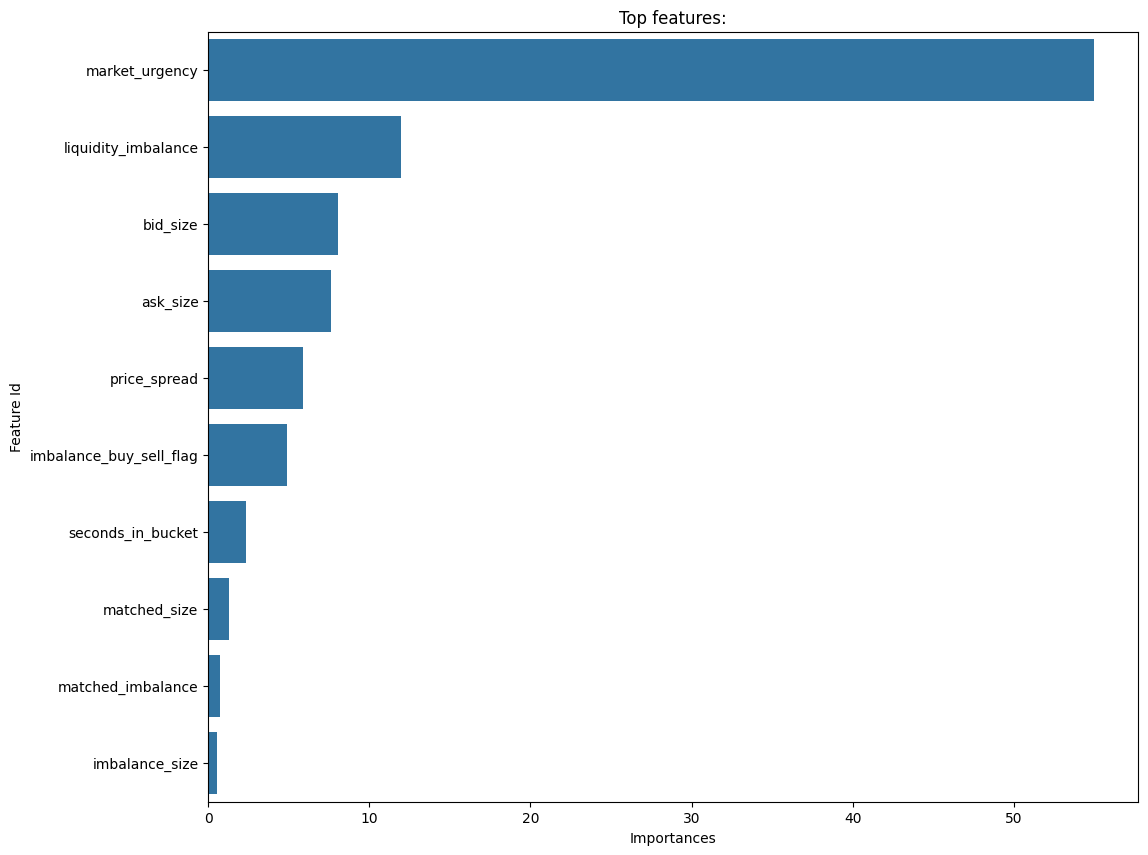

In [18]:
feat_importances = final_model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances[0:10])
plt.title('Top features:');

## Make final predictions

In [19]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [20]:
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    
    # preprocess
    X_test = test[features].copy(deep=True)
    X_test = feature_engineering(X_test)
    
    # predict
    sample_prediction['target'] = final_model.predict(X_test)
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


array([[<Axes: title={'center': 'target'}>]], dtype=object)

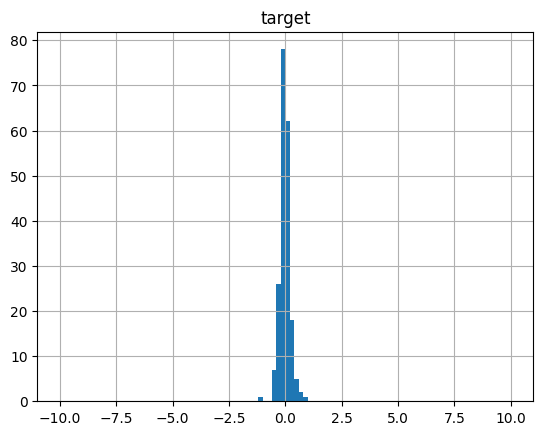

In [21]:
sample_prediction.hist(column='target', bins=100, range=[-10,10])

In [22]:
sample_prediction.to_csv('preds.csv')

# RandomForest model

In [23]:
%who

CatBoostRegressor	 EFeaturesSelectionAlgorithm	 EShapCalcType	 Pool	 X	 X_test	 X_train	 X_val	 combinations	 
counter	 env	 feat_importances	 feature_engineering	 features	 final_model	 final_params	 iter_test	 key	 
mean_absolute_error	 model	 np	 number_of_days	 optiver2023	 os	 params	 pd	 plt	 
revealed_targets	 sample_prediction	 shap	 sns	 test	 testing_days	 testing_mask	 train	 train_pool	 
training_days	 training_mask	 updates	 val_pool	 value	 y	 y_train	 y_val	 y_val_mae	 
y_val_pred	 


## Fill NaN with mean

In [24]:
# Fill NaN with mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train3 = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val3 = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
y_train3 = y_train
y_val3 = y_val

# Проверка размеров новых данных
print("Размер X_train3:", X_train3.shape)
print("Размер X_val3:", X_val3.shape)
print("Размер y_train3:", y_train3.shape)
print("Размер y_val3:", y_val3.shape)

Размер X_train3: (5138892, 17)
Размер X_val3: (99000, 17)
Размер y_train3: (5138892,)
Размер y_val3: (99000,)


In [ ]:
%%time

from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error

# Целевая функция для оптимизации
def objective(params):
    integer_params = ['n_estimators', 'max_depth', 'min_samples_leaf', 'min_samples_split']
    for param in integer_params:
        params[param] = int(params[param])
        
    # Создание модели RandomForest с переданными параметрами
    model = RandomForestRegressor(n_estimators=int(params['n_estimators']),
                                  max_depth=int(params['max_depth']),
                                  min_samples_leaf=int(params['min_samples_leaf']),
                                  min_samples_split=int(params['min_samples_split']),
                                  random_state=42, n_jobs=-1)
    
    # Оценка модели с использованием кросс-валидации и MAE
    model.fit(X_train3, y_train3)
    pred_val = model.predict(X_val3)
    score_val = mean_absolute_error(y_val3, pred_val)
    
    # Возвращаем среднюю абсолютную ошибку
    return score_val

# Пространство поиска параметров
space = {
    'n_estimators':hp.uniform('n_estimators',10,200),
    'max_depth':hp.uniform('max_depth',1,10),
    'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
    'min_samples_split':hp.uniform('min_samples_split',2,4)
}

trial=Trials()
# Запуск оптимизации
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trial,
            max_evals=10)  # Количество итераций оптимизации

print("Лучшие параметры:", best)
# Лучшие параметры: {'max_depth': 8.567822807835242, 'min_samples_leaf': 2.3577155274455373, 'min_samples_split': 3.599106077344635, 'n_estimators': 176.36415437301582}
# CPU times: user 3h 10min 34s, sys: 30.5 s, total: 3h 11min 5s
# Wall time: 24min 59s

 30%|██████████████▍                                 | 3/10 [27:44<1:20:31, 690.19s/trial, best loss: 5.598229417744103]

In [ ]:
best

In [ ]:
rf_params = {'max_depth': int(best['max_depth']),
             'min_samples_leaf': int(best['min_samples_leaf']),
             'min_samples_split': int(best['min_samples_split']),
             'n_estimators': int(best['n_estimators']),
             'random_state':42}
rf_params

In [26]:
#rf_params = {'max_depth': 15, 'n_estimators': 100}
rf_params = {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108, 'random_state': 42}
rf_params

{'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 108,
 'random_state': 42}

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Инициализация и обучение модели RandomForestRegressor
reg = RandomForestRegressor(**rf_params, n_jobs=-1)
reg.fit(X_train3, y_train3)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовом наборе
y_val_pred3 = reg.predict(X_val3)

# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val3, y_val_pred3)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")
# RandomForestRegressor(n_estimators=2, random_state=42, n_jobs=-1) - MAE = 6.421128252465519
# RandomForestRegressor{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108} - MAE = 4.650839659632199
# RandomForestRegressor{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 176} - MAE = 5.598373134316486
# RandomForestRegressor{'max_depth': 16.0, 'n_estimators': 95.0} - MAE = 5.600481479029908
# RandomForestRegressor{'max_depth': 15.0, 'n_estimators': 100.0} - MAE = 5.600940496871642

## Removed NaN

In [26]:
# Remove NaN
import pandas as pd

# Удаление строк с пропущенными значениями из X_train и соответствующие метки y_train
X_train2 = X_train.dropna()
y_train2 = y_train[X_train2.index]

groups = X_train2[['stock_id']].values

X_val2 = X_val.dropna()
y_val2 = y_val[X_val2.index] # соответствующие метки

# Проверка размеров новых данных
print("Размер X_train2:", X_train2.shape)
print("Размер y_train2:", y_train2.shape)
print("Размер X_val2:", X_val2.shape)
print("Размер y_val2:", y_val2.shape)
print("Размер groups:", groups.shape)

Размер X_train2: (2299468, 17)
Размер y_train2: (2299468,)
Размер X_val2: (44170, 17)
Размер y_val2: (44170,)
Размер groups: (2299468, 1)


In [60]:
%%time

from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error

# Целевая функция для оптимизации
def objective(params):
    integer_params = ['n_estimators', 'max_depth', 'min_samples_leaf', 'min_samples_split']
    for param in integer_params:
        params[param] = int(params[param])
        
    # Создание модели RandomForest с переданными параметрами
    model = RandomForestRegressor(n_estimators=int(params['n_estimators']),
                                  max_depth=int(params['max_depth']),
                                  min_samples_leaf=int(params['min_samples_leaf']),
                                  min_samples_split=int(params['min_samples_split']),
                                  random_state=42, n_jobs=-1)
    
    # Оценка модели с использованием кросс-валидации и MAE
    model.fit(X_train2, y_train2)
    pred_val = model.predict(X_val2)
    score_val = mean_absolute_error(y_val2, pred_val)
    
    # Возвращаем среднюю абсолютную ошибку
    return score_val

# Пространство поиска параметров
space = {
    'n_estimators':hp.uniform('n_estimators',10,200),
    'max_depth':hp.uniform('max_depth',5,15),
    'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
    'min_samples_split':hp.uniform('min_samples_split',2,4)
}

trial=Trials()
# Запуск оптимизации
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trial,
            max_evals=)  # Количество итераций оптимизации

print("Лучшие параметры:", best)
# Лучшие параметры: {'max_depth': 6.310584517959263, 'min_samples_leaf': 3.514144882480505, 'min_samples_split': 2.4117253014985915, 'n_estimators': 108.91961721708014}
# CPU times: user 58min 50s, sys: 3.05 s, total: 58min 53s
# Wall time: 7min 45s

100%|███████████████████████████████████████████████████| 2/2 [07:45<00:00, 232.58s/trial, best loss: 4.651306853796193]
Лучшие параметры: {'max_depth': 6.310584517959263, 'min_samples_leaf': 3.514144882480505, 'min_samples_split': 2.4117253014985915, 'n_estimators': 108.91961721708014}
CPU times: user 58min 50s, sys: 3.05 s, total: 58min 53s
Wall time: 7min 45s


In [61]:
trial.best_trial['misc']['vals']

{'max_depth': [6.310584517959263],
 'min_samples_leaf': [3.514144882480505],
 'min_samples_split': [2.4117253014985915],
 'n_estimators': [108.91961721708014]}

In [32]:
rf_params = {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108, 'random_state':42}

In [62]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Инициализация и обучение модели RandomForestRegressor
rf_params = {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108, 'random_state':42}
reg = RandomForestRegressor(**rf_params, n_jobs=-1)
reg.fit(X_train2, y_train2)

CPU times: user 38min 4s, sys: 625 ms, total: 38min 4s
Wall time: 4min 58s


RandomForestRegressor(max_depth=6, min_samples_leaf=4, n_estimators=108,
                      n_jobs=-1, random_state=42)

In [63]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовом наборе
y_val_pred = reg.predict(X_val2)

# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val2, y_val_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")
# RandomForestRegressor(n_estimators=2, random_state=42, n_jobs=-1) - MAE = 6.421128252465519
# RandomForestRegressor{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108} - MAE = 4.650839659632199
# RandomForestRegressor{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 176} - MAE = 5.598373134316486

Mean Absolute Error (MAE) on validation set: 4.650839659632199


# LightGBM

In [ ]:
from lightgbm import LGBMRegressor
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error

# Целевая функция для оптимизации
def objective(params):
    integer_params = ['max_depth', 'max_bin', 'min_data_in_leaf', 'min_data_in_bin']
    for param in integer_params:
        params[param] = int(params[param])
        
    # Создание модели RandomForest с переданными параметрами
    model = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbose=-1)
    
    # Оценка модели с использованием кросс-валидации и MAE
    model.fit(X_train3, y_train3)
    pred_val = model.predict(X_val3)
    score_val = mean_absolute_error(y_val3, pred_val)
    
    # Возвращаем среднюю абсолютную ошибку
    return score_val

# Пространство поиска параметров
space = {
    'max_depth': hp.uniform('max_depth', 1, 10),
    'max_bin': hp.uniform('max_bin', 8, 128),
    'min_data_in_leaf': hp.uniform('min_data_in_leaf', 1, 128),
    'min_data_in_bin': hp.uniform('min_data_in_bin', 1, 128),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
}

trial=Trials()
# Запуск оптимизации
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trial,
            max_evals=50)  # Количество итераций оптимизации

print("Лучшие параметры:", best)
# 100%|████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.72s/trial, best loss: 5.586901350208979]
# Лучшие параметры: {'lambda_l1': 4.018491344117171, 'lambda_l2': 0.8974631475521905, 'learning_rate': 0.1344734584967915, 'max_bin': 24.91893987386775,
#                    'max_depth': 9.710960846688883, 'min_data_in_bin': 71.94624932857133, 'min_data_in_leaf': 52.698863279044886}

In [ ]:
best

In [ ]:
lgbm_params = {'lambda_l1': best['lambda_l1'],
               'lambda_l2': best['lambda_l2'],
               'learning_rate': best['learning_rate'],
               'max_bin': int(best['max_bin']),
               'max_depth': int(best['max_depth']),
               'min_data_in_bin': int(best['min_data_in_bin']),
               'min_data_in_leaf': int(best['min_data_in_leaf']),
               'random_state':42}

In [27]:
lgbm_params = {'lambda_l1': 0.983981994876158, 'lambda_l2': 1.462348885589403, 'learning_rate': 0.051986060592623076,
               'max_bin': 33, 'max_depth': 2, 'min_data_in_bin': 17, 'min_data_in_leaf': 53, 'random_state': 42}
lgbm_params

{'lambda_l1': 0.983981994876158,
 'lambda_l2': 1.462348885589403,
 'learning_rate': 0.051986060592623076,
 'max_bin': 33,
 'max_depth': 2,
 'min_data_in_bin': 17,
 'min_data_in_leaf': 53,
 'random_state': 42}

In [ ]:
%%time

from lightgbm import LGBMRegressor

# Инициализация и обучение модели RandomForestRegressor
lgbm_params = {'lambda_l1': best['lambda_l1'],
               'lambda_l2': best['lambda_l2'],
               'learning_rate': best['learning_rate'],
               'max_bin': int(best['max_bin']),
               'max_depth': int(best['max_depth']),
               'min_data_in_bin': int(best['min_data_in_bin']),
               'min_data_in_leaf': int(best['min_data_in_leaf']),
               'random_state':42}
lgbm = LGBMRegressor(**lgbm_params, n_jobs=-1, verbose=-1)
lgbm.fit(X_train3, y_train3)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовом наборе
y_val_pred = lgbm.predict(X_val3)

# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val3, y_val_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")
'''
RandomForestRegressor(n_estimators=2, random_state=42) - MAE = 6.421128252465519
RandomForestRegressor{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108} - MAE = 4.650839659632199
RandomForestRegressor{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 176} - MAE = 5.598373134316486
LGBMRegressor(lambda_l1=0.983981994876158, lambda_l2=1.462348885589403, learning_rate=0.051986060592623076,
              max_bin=33, max_depth=2, min_data_in_bin=17, min_data_in_leaf=53) - MAE = 5.6032810566059466
'''

# Stacking

In [ ]:
rf_params

In [ ]:
lgbm_params

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
rf = RandomForestRegressor(**rf_params, n_jobs=-1)
lgbm = LGBMRegressor(**lgbm_params, n_jobs=-1, verbose=-1)

In [ ]:
%%time

from sklearn.model_selection import GroupKFold

rf_preds = []
lgbm_preds = []
cv = GroupKFold(n_splits=5)
groups = X_train3[['stock_id']].values
for train_idx, val_idx in cv.split(X_train3, y_train3, groups = groups):
    rf = RandomForestRegressor(**rf_params, n_jobs=-1)
    lgbm = LGBMRegressor(**lgbm_params, n_jobs=-1, verbose=-1)
    X_train_cv, y_train_cv = X_train3.iloc[train_idx, :].drop(columns='stock_id'), y_train3.iloc[train_idx]
    X_val, y_val = X_train3.iloc[val_idx, :].drop(columns='stock_id'), y_train3.iloc[val_idx]
    rf.fit(X_train_cv, y_train_cv)
    rf_pred = rf.predict(X_val)
    rf_preds.append(rf_pred)
    lgbm.fit(X_train_cv, y_train_cv)
    lgbm_pred = lgbm.predict(X_val)
    lgbm_preds.append(lgbm_pred)
    
    rf_score = mean_absolute_error(y_val, rf_pred)
    lgbm_score = mean_absolute_error(y_val, lgbm_pred)
    
    print(rf_score, lgbm_score)

In [ ]:
train_features = np.concatenate((np.hstack(rf_preds).reshape(-1, 1), np.hstack(lgbm_preds).reshape(-1, 1)), axis=1)

In [ ]:
print(train_features)
print(train_features.shape)

In [ ]:
np.save('./train_features.npy', train_features)

In [ ]:
test_features = []
rf.fit(X_train3.drop(columns='stock_id'), y_train3)
test_features.append(rf.predict(X_val3.drop(columns='stock_id')))
lgbm.fit(X_train3.drop(columns='stock_id'), y_train3)
test_features.append(lgbm.predict(X_val3.drop(columns='stock_id')))

In [ ]:
test_features = np.concatenate((test_features[0].reshape(-1, 1), test_features[1].reshape(-1, 1)), axis=1)

In [ ]:
print(test_features)
print(test_features.shape)

In [ ]:
np.save('./test_features.npy', test_features)

In [ ]:
train_features = np.load('./train_features.npy')
print(train_features)
print(train_features.shape)

In [ ]:
test_features = np.load('./test_features.npy')
print(test_features)
print(test_features.shape)

In [ ]:
from catboost import CatBoostRegressor
meta_model = CatBoostRegressor(random_seed=42, verbose=False, loss_function='MAE')

In [ ]:
%%time

meta_model.fit(train_features, y_train3)
meta_test_predict = meta_model.predict(test_features)

In [ ]:
# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val3, meta_test_predict)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")

# StackingRegressor test

In [ ]:
%%time

from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GroupKFold

estimators = [('rf2', rf), ('lgbm2', lgbm)]

cv = GroupKFold(n_splits=5)
# groups = X_train3[['stock_id']].values

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=rf,
    cv = cv,
    n_jobs = -1
)

# Обучение модели
stacking_regressor.fit(X_train3, y_train3)
# CPU times: user 12min 4s, sys: 44.7 s, total: 12min 49s
# Wall time: 1h 24min 23s

In [ ]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовом наборе
y_val_pred = stacking_regressor.predict(X_val3)

# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val3, y_val_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")
# Mean Absolute Error (MAE) on validation set: 5.601649984021021
'''
RandomForestRegressor(n_estimators=2, random_state=42) - MAE = 6.421128252465519
RandomForestRegressor{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108} - MAE = 4.650839659632199
RandomForestRegressor{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 176} - MAE = 5.598373134316486
LGBMRegressor(lambda_l1=0.983981994876158, lambda_l2=1.462348885589403, learning_rate=0.051986060592623076,
              max_bin=33, max_depth=2, min_data_in_bin=17, min_data_in_leaf=53) - MAE = 5.6032810566059466
StackingRegressor(
    estimators = RandomForestRegressor('max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108),
                 LGBMRegressor(lambda_l1=0.983981994876158, lambda_l2=1.462348885589403, learning_rate=0.051986060592623076,
                               max_bin=33, max_depth=2, min_data_in_bin=17, min_data_in_leaf=53)
    final_estimator = RandomForestRegressor('max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 108)
) - MAE = 5.601649984021021
'''

# OLD

In [50]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Инициализация и обучение модели RandomForestRegressor
reg = RandomForestRegressor(n_estimators=2, random_state=42, n_jobs=-1)
reg.fit(X_train2, y_train2)

# Предсказание на тестовом наборе
#y_pred = reg.predict(X_val2)

CPU times: user 7min 46s, sys: 2.08 s, total: 7min 48s
Wall time: 2min 1s


RandomForestRegressor(n_estimators=2, n_jobs=-1, random_state=42)

In [51]:
from sklearn.metrics import mean_absolute_error

# Предсказание на тестовом наборе
y_val_pred = reg.predict(X_val2)

# Оценка MAE на тестовом наборе
mae = mean_absolute_error(y_val2, y_val_pred)
print(f"Mean Absolute Error (MAE) on validation set: {mae}")
# RandomForestRegressor(n_estimators=2, random_state=42, n_jobs=-1) - MAE = 6.421128252465519

Mean Absolute Error (MAE) on validation set: 6.421128252465519


In [ ]:
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error

# Целевая функция для оптимизации
def objective(params):
    # Создание модели RandomForest с переданными параметрами
    model = RandomForestRegressor(n_estimators=int(params['n_estimators']),
                                  max_depth=int(params['max_depth']),
                                  random_state=42, n_jobs=-1)
    
    # Оценка модели с использованием кросс-валидации и MAE
    model.fit(X_train2, y_train2)
    pred_val = model.predict(X_val2)
    score_val = mean_absolute_error(y_val2, pred_val)
    
    # Возвращаем среднюю абсолютную ошибку
    return score_val

# Пространство поиска параметров
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 1, 20, 1)
}

# Запуск оптимизации
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)  # Количество итераций оптимизации

print("Лучшие параметры:", best)


 22%|██████████▎                                    | 11/50 [40:52<3:15:34, 300.89s/trial, best loss: 4.636188862423079]